In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from scipy.linalg import block_diag
from sklearn.utils import check_random_state

### SNIPPET4.1

In [43]:
def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10):
    x = ((1-corr0.fillna(0))/2.)**0.5
    silh = pd.Series()
    for init in range(n_init):
        for i in range(2, maxNumClusters+1):
            kmeans_ = KMeans(n_clusters=i, n_jobs=1, n_init=1)
            kmeans_ = kmeans_.fit(x)
            silh_ = silhouette_samples(x, kmeans_.labels_)
            stat = (silh_.mean() / silh_.std(), silh.mean() / silh.std())
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh, kmeans = silh_, kmeans_
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx]
    
    corr1 = corr1.iloc[:, newIdx]
    clstrs = {
        i : corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)
    }
    silh = pd.Series(silh, index = x.index)
    return corr1, clstrs, silh

### SNIPPET4.2

In [44]:
def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew = {}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    newIdx = [ j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]
    x = ((1 - corr0.fillna(0))/2.)**0.5
    kmeans_labels = np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs = [x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i
    silhNew = pd.Series(silhouette_samples(x, kmeans.labels),
                       index = x.index)
    return corrNew, clstrsNew, silhNew

In [85]:
def clusterKMeansTop(corr0, maxNumClusters = None, n_init = 10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1
    corr1, clstrs, silh = clusterKMeansBase(corr0, 
                                            maxNumClusters = min(maxNumClusters, corr0.shape[1]-1),
                                            n_init=n_init)
    clusterTstats = {i:np.mean(silh[clstrs[i]]) / np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = sum(clusterTstats.values()) / len(clusterTstats)
    redoClusters = [ i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    if len(redoClusters) <= 1:
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        tStatMean = np.mean([clusterTstats[i] for i in redoClusters])
        corr2, clstrs2, silh2 = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, 
                                                     {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters},
                                                     clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/
                               np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            return corr1, clstrs, silh
        else:
            return corrNew, clstrsNew, silhNew
    
                                   

### SNIPPET 4.3

In [86]:
def getCovSub(nObs, nCols, sigma, random_state = None):
    rng = check_random_state(random_state)
    if nCols == 1:
        return np.ones((1,1))
    ar0 = rng.normal(size = (nObs, 1))
    ar0 = np.repeat(ar0, nCols, axis = 1)
    ar0 += rng.normal(scale = sigma, size = ar0.shape)
    ar0 = np.cov(ar0, rowvar=False)
    return ar0

In [87]:
def getRndBlockCov(nCols, nBlocks, minBlockSize = 1, sigma = 1., random_state = None):
    rng = check_random_state(random_state)
    parts = rng.choice(range(1, nCols - (minBlockSize-1)*nBlocks), nBlocks-1, replace = False)
    parts.sort()
    parts = np.append(parts, nCols - (minBlockSize - 1) * nBlocks)
    parts = np.append(parts[0], np.diff(parts)) - 1 + minBlockSize
    cov = None
    for nCols_ in parts:
        cov_ = getCovSub(int(max(nCols_ * (nCols_ + 1) / 2., 100)), nCols_, sigma, random_state=rng)
        if cov is None:
            cov = cov_.copy()
        else:
            cov = block_diag(cov, cov_)    
    return cov

In [88]:
def randomBlockCorr(nCols, nBlocks, random_state = None, minBlockSize = 1):
    rng = check_random_state(random_state)
    cov0 = getRndBlockCov(nCols, nBlocks, minBlockSize=minBlockSize, sigma = 0.5, random_state=rng)
    cov1 = getRndBlockCov(nCols, 1, minBlockSize=minBlockSize, sigma = 1., random_state=rng)
    cov0 += cov1
    corr0 = cov2corr(cov0)
    corr0 = pd.DataFrame(corr0)
    return corr0

In [89]:
def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1
    return corr

In [90]:
corr = randomBlockCorr(30, 6, )

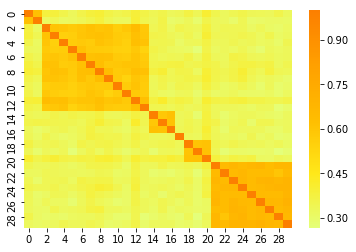

In [91]:
import seaborn as sns
%matplotlib inline
sns.heatmap(corr, cmap="Wistia")

In [93]:
corrNew, clstr, silh = clusterKMeansTop(corr)

/Users/yuseki/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


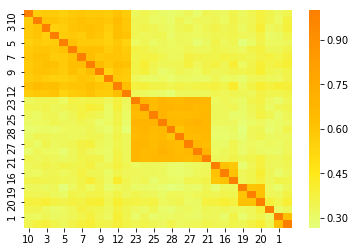

In [95]:
sns.heatmap(corrNew, cmap="Wistia")

In [96]:
clstr

{0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 1: [21, 22, 23, 24, 25, 26, 27, 28, 29],
 2: [14, 15, 16],
 3: [18, 19, 20],
 4: [17],
 5: [0, 1]}

In [98]:
path = r"https://www.mof.go.jp/english/jgbs/reference/interest_rate/historical/jgbcme_all.csv"
raw = pd.read_csv(path, header=1, index_col="Date")

In [133]:
# columns = ['2Y', '5Y', '7Y', '10Y', '15Y', '20Y', '30Y', '40Y']
columns = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '15Y', '20Y', '25Y', '30Y', '40Y']
data = np.array(raw[columns][(raw.index > '2012/3/1') & (raw.index < '2015/6/1')], dtype = np.float64)

In [134]:
cov = np.cov(data.T)
corr0 = pd.DataFrame(cov2corr(cov), columns = columns)
corr0.index = columns

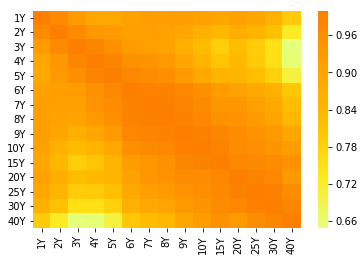

In [135]:
sns.heatmap(corr0, cmap="Wistia")

In [136]:
corr1, clstr1, silh1 = clusterKMeansTop(corr0)

In [137]:
clstr1

{0: ['9Y', '10Y', '15Y', '20Y', '25Y', '30Y', '40Y'],
 1: ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y']}